In [1]:
import pickle
import numpy as np
from pathlib import Path
from music21 import converter, clef, stream, pitch, note, meter, midi, instrument
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import History, ModelCheckpoint
from keras.optimizers import RMSprop
from utils import unpack_corpus, create_png_from_stream, create_midi_from_stream, upload_to_s3_bucket

Using TensorFlow backend.


In [2]:
midi_files = []
#for suite in ['1007', '1008', '1009', '1010', '1011', '1012']:
for suite in ['1007']:
    for mvt in ['1', '2', '3', '4', '5', '6']:
        filename = 'bach_suites/bwv{}_0{}.mid'.format(suite, mvt)
        midi_files.append(filename)

phrase_lengths = [10, 20, 35, 50]
layer_size = 512
step_size = 3
batch_size = 256
#nb_epoch = 700
nb_epoch = 10

corpus_data = {}

In [4]:
def parse_notes(midi_stream):
    melody_corpus = []

    last_pitch = 1
    chord_buffer = []
    prev_offset = 0.0
    for m in midi_stream.measures(1, None):
        time_sig = m.timeSignature
        for nr in m.flat.notesAndRests:
            offset_loc = nr.offset
            # pitch = nr.pitch.pitchClass + 1  if isinstance(nr, note.Note) else 0
            pitch = nr.pitch.midi  if isinstance(nr, note.Note) else 0
            beat_strength = round(nr.beatStrength * 4.0, 0)
            duration = float(nr.quarterLength)

            note_repr = (pitch, beat_strength, duration)
            # note_repr = (pitch, duration)
            # Handle chords
            if nr.offset == prev_offset:
                if note_repr[0] > 0:
                    chord_buffer.append(note_repr)
            else:
                if chord_buffer: # Choose tone from chord buffer closest to current note
                    chord_melody_tone = sorted(chord_buffer, key=lambda x: abs(x[0] - pitch))[0]
                    melody_corpus.append(chord_melody_tone)
                melody_corpus.append(note_repr)
                chord_buffer = []
            prev_offset = nr.offset

    return melody_corpus

In [5]:
def build_corpus(midi_files):
    melody_corpus = []
    for file in midi_files:
        midi_stream = converter.parse(file)
        midi_stream = midi_stream[0]
        if '1008' in file or '1011' in file:
            midi_stream.keySignature = midi_stream.keySignature.relative
        key_sig = midi_stream.keySignature
        print('Input file: {} ({})'.format(file, str(key_sig)))
        midi_stream.transpose(KEY_SIG_OFFSET - key_sig.tonic.pitchClass, inPlace=True)
        melody_corpus.extend(parse_notes(midi_stream))
    # map indices for constructing matrix representations
    melody_set = set(melody_corpus)
    notes_indices = {note: i for i, note in enumerate(melody_set)}
    indices_notes = {i: note for i, note in enumerate(melody_set)}

    return melody_corpus, melody_set, notes_indices, indices_notes

In [6]:
def train_model(midi_files, save_path, model_path=None, step_size=3, phrase_len=20, layer_size=128, batch_size=128, nb_epoch=1):

    melody_corpus, melody_set, notes_indices, indices_notes = build_corpus(midi_files)

    corpus_size = len(melody_set)

    # cut the corpus into semi-redundant sequences of max_len values
    # step_size = 3
    # phrase_len = 20
    phrases = []
    next_notes = []
    for i in range(0, len(melody_corpus) - phrase_len, step_size):
        phrases.append(melody_corpus[i: i + phrase_len])
        next_notes.append(melody_corpus[i + phrase_len])
    print('nb sequences:', len(phrases))

    # transform data into binary matrices
    X = np.zeros((len(phrases), phrase_len, corpus_size), dtype=np.bool)
    y = np.zeros((len(phrases), corpus_size), dtype=np.bool)
    for i, phrase in enumerate(phrases):
        for j, note in enumerate(phrase):
            X[i, j, notes_indices[note]] = 1
        y[i, notes_indices[next_notes[i]]] = 1
    if model_path is None:
        model = Sequential()
        model.add(LSTM(layer_size, return_sequences=True, input_shape=(phrase_len, corpus_size)))
        model.add(Dropout(0.2))
        model.add(LSTM(layer_size, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(corpus_size))
        model.add(Activation('softmax'))

        model.compile(loss='categorical_crossentropy', optimizer=RMSprop())

    else:
        model = load_model(model_path)

    checkpoint = ModelCheckpoint(filepath=save_path,
        verbose=1, save_best_only=False)
    history = History()
    model.fit(X, y, batch_size=batch_size, epochs=nb_epoch, callbacks=[checkpoint, history])

    return model, melody_corpus, melody_set, notes_indices, indices_notes

In [8]:
param_str = '{}_{}_{}'.format(step_size, phrase_len, layer_size)

In [9]:
param_str

'3_50_512'

In [14]:
save_path = 'model_save/bach_model_{}.h5'.format(param_str)

In [15]:
save_path

'model_save/bach_model_3_50_512.h5'

In [16]:
model_path = save_path if Path(save_path).is_file() else None

In [17]:
model_path

'model_save/bach_model_3_50_512.h5'

In [18]:
#model, melody_corpus, melody_set, notes_indices, indices_notes = train_model(midi_files, save_path, model_path, step_size, phrase_len, layer_size, batch_size, nb_epoch)

In [20]:
KEY_SIG_OFFSET = 0

In [21]:
melody_corpus, melody_set, notes_indices, indices_notes = build_corpus(midi_files)

Input file: bach_suites/bwv1007_01.mid (G major)
Input file: bach_suites/bwv1007_02.mid (G major)
Input file: bach_suites/bwv1007_03.mid (G major)
Input file: bach_suites/bwv1007_04.mid (G major)
Input file: bach_suites/bwv1007_05.mid (G major)
Input file: bach_suites/bwv1007_06.mid (G major)


In [37]:
melody_corpus[:5]

[(36, 4.0, 0.25),
 (43, 0.0, 0.25),
 (52, 0.0, 0.25),
 (50, 0.0, 0.25),
 (52, 1.0, 0.25)]

In [29]:
type(melody_set)

set

In [38]:
list(melody_corpus)[:5]


[(36, 4.0, 0.25),
 (43, 0.0, 0.25),
 (52, 0.0, 0.25),
 (50, 0.0, 0.25),
 (52, 1.0, 0.25)]

In [44]:
list(notes_indices)[:5]

[(43, 1.0, 0.25),
 (52, 2.0, 0.25),
 (0, 0.0, 1.3333333333333333),
 (36, 0.0, 0.25),
 (38, 4.0, 0.5)]

In [57]:
type(notes_indices)

dict

In [58]:
type(indices_notes)

dict

In [59]:
melody_corpus

[(36, 4.0, 0.25),
 (43, 0.0, 0.25),
 (52, 0.0, 0.25),
 (50, 0.0, 0.25),
 (52, 1.0, 0.25),
 (43, 0.0, 0.25),
 (52, 0.0, 0.25),
 (43, 0.0, 0.25),
 (36, 2.0, 0.25),
 (43, 0.0, 0.25),
 (52, 0.0, 0.25),
 (50, 0.0, 0.25),
 (52, 1.0, 0.25),
 (43, 0.0, 0.25),
 (52, 0.0, 0.25),
 (43, 0.0, 0.25),
 (36, 4.0, 0.25),
 (45, 0.0, 0.25),
 (53, 0.0, 0.25),
 (52, 0.0, 0.25),
 (53, 1.0, 0.25),
 (45, 0.0, 0.25),
 (53, 0.0, 0.25),
 (45, 0.0, 0.25),
 (36, 2.0, 0.25),
 (45, 0.0, 0.25),
 (53, 0.0, 0.25),
 (52, 0.0, 0.25),
 (53, 1.0, 0.25),
 (45, 0.0, 0.25),
 (53, 0.0, 0.25),
 (45, 0.0, 0.25),
 (36, 4.0, 0.25),
 (47, 0.0, 0.25),
 (53, 0.0, 0.25),
 (52, 0.0, 0.25),
 (53, 1.0, 0.25),
 (47, 0.0, 0.25),
 (53, 0.0, 0.25),
 (47, 0.0, 0.25),
 (36, 2.0, 0.25),
 (47, 0.0, 0.25),
 (53, 0.0, 0.25),
 (52, 0.0, 0.25),
 (53, 1.0, 0.25),
 (47, 0.0, 0.25),
 (53, 0.0, 0.25),
 (47, 0.0, 0.25),
 (36, 4.0, 0.25),
 (48, 0.0, 0.25),
 (52, 0.0, 0.25),
 (50, 0.0, 0.25),
 (52, 1.0, 0.25),
 (48, 0.0, 0.25),
 (52, 0.0, 0.25),
 (48, 0.0,

In [61]:
f = 'bach_suites/bwv{}_0{}.mid'.format('1007', '1')
md = converter.parse(f)

In [62]:
f

'bach_suites/bwv1007_01.mid'

In [63]:
md

<music21.stream.Score 0x1158f7b8>

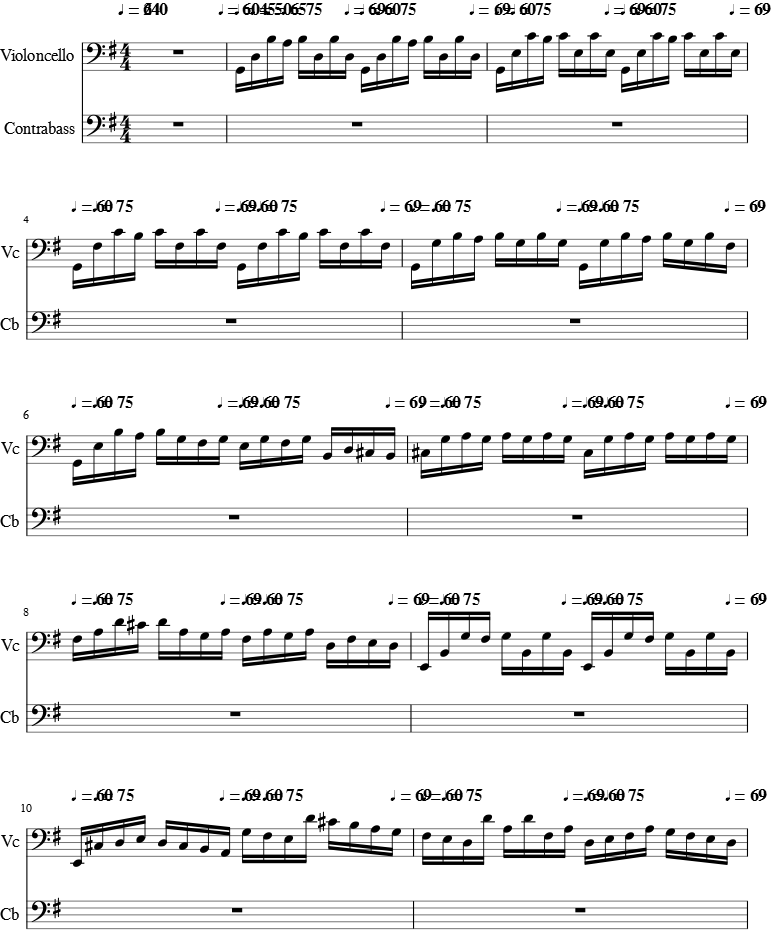

In [64]:
md.show()

In [65]:
def play_melody(gen_melody):
    v = stream.Voice()
    last_note_duration = 0
    for n in gen_melody:
        if n[0] == 0:
            new_note = note.Rest()
        else:
            new_pitch = pitch.Pitch()
            # new_pitch.midi = 59.0 + n[0] - 24
            new_pitch.midi = n[0]
            new_note = note.Note(new_pitch)
        new_note.offset = v.highestOffset + last_note_duration
        new_note.duration.quarterLength = n[2]
        last_note_duration = new_note.duration.quarterLength
        v.insert(new_note)
    s = stream.Stream()
    part = stream.Part()
    part.clef = clef.BassClef()
    part.append(instrument.Harpsichord())
    part.insert(v)
    s.insert(part)

    return s

In [66]:
inverso = play_melody(melody_corpus)

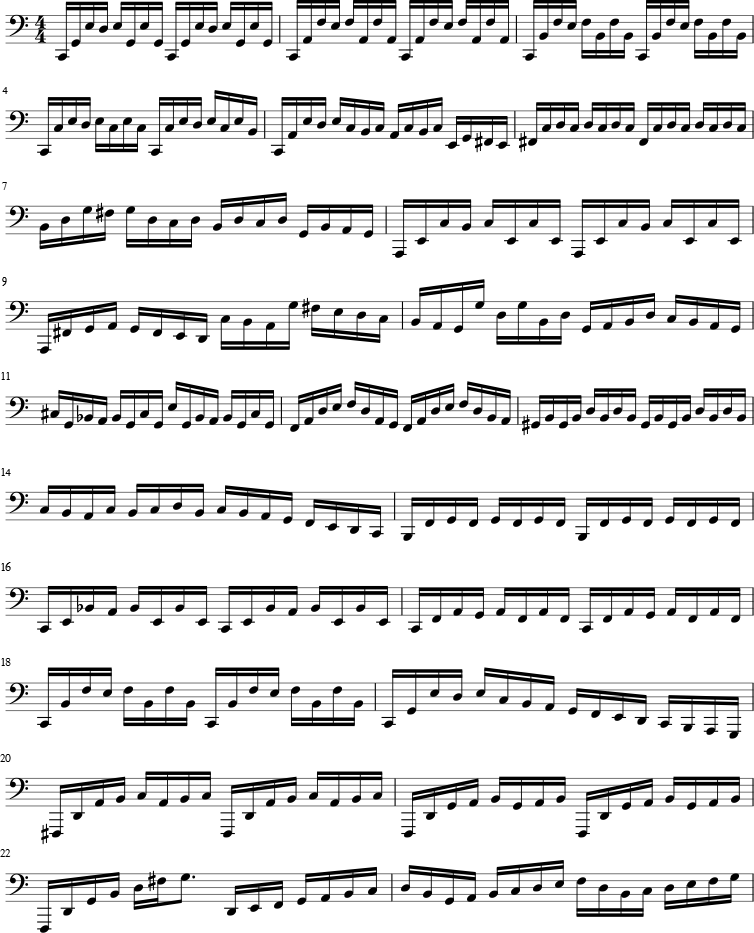

In [68]:
inverso.show()